In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import math
from functools import partial

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from models.transformer import VisionTransformer

%load_ext autoreload
%autoreload 2

In [2]:
from models.mlp_mixer import MLPMixer

mlp_mixer = MLPMixer(patch_size=4, channels=1, tokens_dim=64, mlp_dim=128, num_blocks=8)

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (4, 28, 28, 1))
mlp_mixer.init_with_output(key, x)[0].shape

(4, 28, 28, 1)

In [2]:
num_batch = 64

# Load MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

# Split dataset into training and testing sets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# Define function to normalize pixel values
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255
    image = (image - 0.5 / 0.5)
    return image, label

# Apply normalization to both training and testing sets
mnist_train = mnist_train.map(normalize)
mnist_test = mnist_test.map(normalize)

# Shuffle and batch the training set
mnist_train = mnist_train.shuffle(mnist_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(num_batch).prefetch(buffer_size=mnist_info.splits['train'].num_examples)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.repeat()

# Batch the testing set
mnist_test = mnist_test.batch(num_batch)

In [3]:
train_iter = iter(mnist_train)
x, y = next(train_iter)

In [2]:
from models.utils import get_timestep_embedding, karras_boundaries, TrainState, apply_ema_decay

In [323]:
def f_theta(params, score, x, t, eps=0.002):
    
    sigma_data = 0.5
    
    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)
    
    t = t[..., 0]
    # t = get_timestep_embedding(t, 16)
    x_out = score.apply(params, x, t)
    
    return x * c_skip[:, None, None] + x_out * c_out[:, None, None]

In [324]:
@partial(jax.jit, static_argnums=(5,))
def loss_fn(params, params_ema, x, t1, t2, score, key):

    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2[:, None, None]
    x2 = f_theta(params, score, x2, t2)
    
    x1 = x + z * t1[:, None, None]
    x1 = f_theta(params_ema, score, x1, t1)
    
    return np.mean((x1 - x2) ** 2) 

In [325]:
from models.unet import Unet

key = jax.random.PRNGKey(42)

# score = VisionTransformer()
score = Unet(dim=32, dim_mults=(1,2,4), resnet_block_groups=4)

x = jax.random.normal(key, (4, 28, 28, 1))
t = np.ones((4))

params = score.init(key, x, t)

In [326]:
t = np.ones((4, 1))
loss_fn(params, params, x, t, t + 0.1, score, key)

Array(0.00489171, dtype=float32)

In [327]:
import optax

tx = optax.adam(learning_rate=6e-4)

state = TrainState.create(
              apply_fn=score.apply, 
              params=params, 
              tx=tx, 
              params_ema=params)

In [328]:
from tqdm import tqdm, trange

num_steps = 10000
    
s0 = 2
s1 = 150
mu0 = 0.9
eps = 0.002
T = 80.


with trange(num_steps) as steps:
    for step in steps:
        
        x_batch, y_batch = next(train_iter)
        x_batch, y_batch = np.array(x_batch), np.array(y_batch)

        N = math.ceil(math.sqrt((step * ((s1 + 1) ** 2 - s0 ** 2) / num_steps) + s0 ** 2) - 1) + 1
        mu = math.exp(s0 * math.log(mu0) / N)
        
        boundaries = karras_boundaries(7.0, eps, N, T)

        key, _ = jax.random.split(key)
        n_batch = jax.random.randint(key, minval=0, maxval=N, shape=(x_batch.shape[0], 1))
        
        key, _ = jax.random.split(key)
        loss, grads = jax.value_and_grad(loss_fn)(state.params, state.params_ema, x_batch, boundaries[n_batch], boundaries[n_batch + 1], score, key)            
        state = state.apply_gradients(grads=grads)
        state = jax.lax.stop_gradient(apply_ema_decay(state, mu))
        
        steps.set_postfix(val=loss)

  1%|▎                                   | 95/10000 [01:26<2:30:08,  1.10it/s, val=1.4853511]


KeyboardInterrupt: 

In [ ]:
def sample(params, score, ts, key):
    
    x0 = jax.random.normal(key, shape=(n_samples, 28, 28, 1)) * ts[0]
    x = f_theta(params, score, x0, np.repeat(ts[0], x0.shape[0])[:, None])
    for t in ts[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = f_theta(params, score, x, np.repeat(t, x0.shape[0])[:, None])
        
    return x

n_samples = 10
x_samples = sample(state.params, score, list(reversed([0.1, 2., T / 4., T / 2., T])), key)

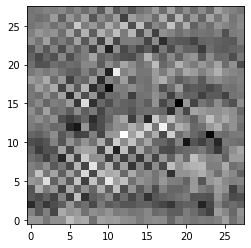

In [272]:
import matplotlib.pyplot as plt

plt.imshow(x_samples[8, :, :, 0], origin='lower', cmap='binary')

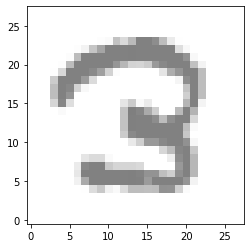

In [237]:
plt.imshow(np.array(x_batch[2, :, :, 0]), origin='lower', cmap='binary', vmin=-1, vmax=1)

In [203]:
x, y = next(train_iter)